### Tree-based Modelling EDA
Using the existing DataLoader and DataCleaner functionality, I aim to explore different tree-based models. I am expecting to settle for a XGBoost model.

I will also use this notebook to explore feature selection techniques 

In [5]:
# Data Preprocessing
from data_preprocessing.DataLoader import DataLoader
from data_preprocessing.DataCleaner import DataCleaner
from sklearn.model_selection import train_test_split

# Modelling
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesClassifier

# Feature Selection
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score, GridSearchCV

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Hyper param Tuning
from hpsklearn import HyperoptEstimator, random_forest_regressor, xgboost_regression
from hyperopt import hp

# General
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# X_train = pd.read_csv('X_train.csv')
# X_test = pd.read_csv('X_test.csv')
# y_train = pd.read_csv('y_train.csv')
# y_test = pd.read_csv('y_test.csv')

In [7]:
data_loader = DataLoader(path="car_data.parquet.gzip")
df = data_loader.load_parquet()
data_cleaner = DataCleaner(df)

data_cleaner.clean_data()
new_df = data_cleaner.get_df()
new_outlier_df = data_cleaner.get_outlier_df()

# Split data and drop old columns
X_train, X_test, y_train, y_test = data_loader.split_data(new_df)
data_cleaner.drop_columns(X_train)
data_cleaner.drop_columns(X_test)
# Encode to ordinal based on train set
columns_to_ordinal = ["co2_grouped", "engine_size_grouped", "owners_grouped", "fuel_type_grouped", "make_grouped", "doors_grouped", "seats_grouped"]
data_cleaner.convert_columns_to_ordinal(columns_to_ordinal, X_train, y_train, X_test)

# Outlier data and drop
X_train_outlier, X_test_outlier, y_train_outlier, y_test_outlier = data_loader.split_data(new_outlier_df, test_size=0.1)
data_cleaner.drop_columns(X_train_outlier)
data_cleaner.drop_columns(X_test_outlier)
# Encode to ordinal based on train set
columns_to_ordinal = ["co2_grouped", "engine_size_grouped", "owners_grouped", "fuel_type_grouped", "make_grouped", "doors_grouped", "seats_grouped"]
data_cleaner.convert_columns_to_ordinal(columns_to_ordinal, X_train_outlier, y_train_outlier, X_test_outlier)

Number of outliers: 2212
Percentage of tota ingest dataset: 0.98%
Number of extreme outliers removed: 171
Percentage of tota ingest dataset: 0.08%


## Feature Selection using an ExtraTreesClassifier
<u> What is an ExtraTrees Model and How does it differ to a Random Forest? </u>  
Extra trees are also know as <a href="https://orbi.uliege.be/bitstream/2268/9357/1/geurts-mlj-advance.pdf"><b>Extremely Random Trees</b></a>

- Random forest uses boostrap replicas (subsamples input with replacement)
- Extra Trees use whole original sample (bootstrapping is optional arg in scikit)
- Random forest chooses the optimum split for each branch
- Extra Trees choose these splits randomly
- Extra trees are computationally more efficient than other ensemble methods

In [8]:
columns_to_keep = ["is_private_plate",
"mileage_deviation_encoded",
"image_count",
"advert_sentiment",
"advert_title_sentiment",
"make_grouped",
"fuel_type_grouped",
"doors_grouped",
"seats_grouped",
"owners_grouped",
"engine_size_grouped",
"co2_grouped"]

outlier_cols_to_keep = [
    'is_ulez', 
    'is_convetible', 
    'is_private_plate', 
    'mileage_deviation_encoded', 
    'image_count', 
    'advert_sentiment', 
    'advert_title_sentiment', 
    'make_grouped', 
    'doors_grouped', 
    'seats_grouped', 
    'owners_grouped', 
    'co2_grouped'
    ]

# X_train = np.array(X_train[columns_to_keep])
# X_test = np.array(X_test[columns_to_keep])
# X_train_outlier = np.array(X_train_outlier[columns_to_keep])
# X_test_outlier = np.array(X_test_outlier[columns_to_keep])

y_train = np.reshape(np.array(y_train), (-1, ))
y_test = np.reshape(np.array(y_test), (-1, ))
y_train_outlier = np.reshape(np.array(y_train_outlier), (-1, ))
y_test_outlier = np.reshape(np.array(y_test_outlier), (-1, ))

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=1337, test_size=0.1)
X_train_outlier, X_val_outlier, y_train_outlier, y_val_outlier = train_test_split(X_train_outlier, y_train_outlier, random_state=1337, test_size=0.1)

extra_tree_clf = ExtraTreesClassifier(n_estimators=20, max_depth=16, min_samples_split=4, random_state=1337, bootstrap=True, n_jobs=-1)

In [9]:
extra_tree_clf.fit(X_train, y_train)
importance_dict = dict(zip(X_train.columns, extra_tree_clf.feature_importances_))
importance_dict = dict(sorted(importance_dict.items(), key=lambda item: item[1], reverse=True))
for k,v in importance_dict.items():
    print(f"{k} : {v}")

image_count : 0.15466657423445326
vehicle_age : 0.1006975009446856
co2_grouped : 0.08598488373594253
make_grouped : 0.07362882391776197
owners_grouped : 0.06696234272830019
advert_sentiment : 0.060916507130318674
advert_title_sentiment : 0.05887517335896896
seats_grouped : 0.04523791044769123
mileage_deviation_encoded : 0.04478667997522667
doors_grouped : 0.03893132281244979
fuel_type_grouped : 0.03707677943923247
engine_size_grouped : 0.03132003613927339
is_private_plate : 0.024104683834575664
is_manual : 0.015364862872501632
is_ulez : 0.014253767676381144
is_convertible : 0.0134846663873
model_col_10 : 0.009192455552839455
model_col_0 : 0.009002271232110295
model_col_2 : 0.008335205141755028
model_col_8 : 0.008301266153077384
model_col_11 : 0.008214975178826456
model_col_6 : 0.00820838698439015
model_col_1 : 0.008170775919493934
model_col_15 : 0.00801303598310584
model_col_14 : 0.007934038043420697
model_col_3 : 0.00787127280089562
model_col_4 : 0.007849132951366867
model_col_12 : 0.

In [10]:
# importance_dict
print(f"Old shape: {X_train.shape}")
model = SelectFromModel(extra_tree_clf, prefit=True)
X_new = model.transform(X_train)
features_out = model.get_feature_names_out(input_features=X_train.columns)
print(f"New shape: {X_new.shape}")

Old shape: (140553, 39)


/opt/anaconda3/envs/pyZak/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


New shape: (140553, 12)


#### Outlier Feature Selection

In [11]:
extra_tree_clf = ExtraTreesClassifier(n_estimators=50, max_depth=16, min_samples_split=4, random_state=1337, bootstrap=True, n_jobs=-1)
extra_tree_clf.fit(X_train_outlier, y_train_outlier)
outlier_importance_dict = dict(zip(X_train_outlier.columns, extra_tree_clf.feature_importances_))
outlier_importance_dict = dict(sorted(outlier_importance_dict.items(), key=lambda item: item[1], reverse=True))
for k,v in outlier_importance_dict.items():
    print(f"{k} : {v}")

# outlier importance_dict
print(f"Old shape: {X_train_outlier.shape}")
outlier_model = SelectFromModel(extra_tree_clf, prefit=True)
X_new_outlier = outlier_model.transform(X_train_outlier)
outlier_features_out = outlier_model.get_feature_names_out(input_features=X_train_outlier.columns)
print(f"New shape: {X_new_outlier.shape}")

image_count : 0.15565697479254725
vehicle_age : 0.10070457972983261
owners_grouped : 0.07978006003663796
mileage_deviation_encoded : 0.06201009861782568
advert_sentiment : 0.05232984057403828
advert_title_sentiment : 0.050785092328208235
seats_grouped : 0.04885036624131061
is_private_plate : 0.04722422109958003
is_convertible : 0.038385256476776666
make_grouped : 0.03733430902633698
doors_grouped : 0.03334771947420271
co2_grouped : 0.0286358681039854
is_ulez : 0.026542354212560137
engine_size_grouped : 0.019941958989243017
is_manual : 0.016742507119521223
model_col_10 : 0.01649409045718213
fuel_type_grouped : 0.015775939002311973
model_col_0 : 0.014091726327665664
model_col_1 : 0.013365469546126961
model_col_11 : 0.013283559585900105
model_col_15 : 0.012862396650320549
model_col_2 : 0.012039390389014191
model_col_9 : 0.011220323541982718
is_imported : 0.01081874970249707
is_new : 0.010237544469068428
model_col_5 : 0.010008064294801666
model_col_8 : 0.009710667332100709
model_col_12 : 0

/opt/anaconda3/envs/pyZak/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [12]:
for f1, f2 in zip(features_out, outlier_features_out):
    print(f"{f1} : {importance_dict[f1]:.4f}\t\t\t{f2} : {outlier_importance_dict[f2]:.4f}")

vehicle_age : 0.1007			is_ulez : 0.0265
mileage_deviation_encoded : 0.0448			is_convertible : 0.0384
image_count : 0.1547			is_private_plate : 0.0472
advert_sentiment : 0.0609			vehicle_age : 0.1007
advert_title_sentiment : 0.0589			mileage_deviation_encoded : 0.0620
make_grouped : 0.0736			image_count : 0.1557
fuel_type_grouped : 0.0371			advert_sentiment : 0.0523
doors_grouped : 0.0389			advert_title_sentiment : 0.0508
seats_grouped : 0.0452			make_grouped : 0.0373
owners_grouped : 0.0670			doors_grouped : 0.0333
engine_size_grouped : 0.0313			seats_grouped : 0.0489
co2_grouped : 0.0860			owners_grouped : 0.0798


### Metric Choice
1. MAE
 - Easy to interpret and gives less weight to outliers
2. MSE
- Will  be sensitive to hypercar outliers and needs reformatting for interpretation
3. RMSE
- Also sensitive to hypercar outliers but already rooted so easier to interpret

## Base Model - Decision Tree

In [13]:
X_train = X_new
model_mask = model.get_support()
outlier_model_mask = outlier_model.get_support()

model_feature_map = dict(zip([_ for _ in range(len(model_mask))], features_out))
outlier_model_feature_map = dict(zip([_ for _ in range(len(outlier_model_mask))], [outlier_features_out]))

X_test = np.array(X_test.loc[:, model_mask])
X_val = np.array(X_val.loc[:, model_mask])

X_train_outlier = X_new_outlier
X_test_outlier = np.array(X_test_outlier.loc[:, outlier_model_mask])
X_val_outlier = np.array(X_val_outlier.loc[:, outlier_model_mask])

def output_score(scores):
    print(f"Mean: {abs(scores.mean()):.3f} (std: {scores.std():.3f})\n\n")

In [14]:
dt = DecisionTreeRegressor(max_depth=32, random_state=1337)
basic_dt_scores = cross_val_score(dt, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

## Random Forest

In [15]:
rf = RandomForestRegressor(n_estimators=100, max_depth=16, random_state=1337, n_jobs=-1)
basic_rf_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

### Gradient Boosting Regressor

In [16]:
gb = GradientBoostingRegressor(n_estimators=100, max_depth=16, random_state=1337, learning_rate=0.3, n_iter_no_change=5)
basic_gb_scores = cross_val_score(gb, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

In [17]:
print("DT")
output_score(basic_dt_scores)
print("RF")
output_score(basic_rf_scores)
print("GB")
output_score(basic_gb_scores)

DT
Mean: 2849.147 (std: 19.414)


RF
Mean: 2288.614 (std: 13.238)


GB
Mean: 2412.758 (std: 14.202)




## Best Performing 'Default' Model: Random Forest
#### Random Forest Hyperparam Tuning

In [18]:
# cv_rf = RandomForestRegressor(random_state=1337)
# param_grid = {'n_estimators':[120], 'max_depth':[16], 'min_samples_split': [16]}
# grid_cv_clf = GridSearchCV(cv_rf, param_grid)
# grid_cv_clf.fit(X_train, y_train)

In [19]:
"""
RandomForestRegressor(max_depth=16, min_samples_split=16, n_estimators=120,
                      random_state=1337)
"""
best_rf = RandomForestRegressor(max_depth=16, min_samples_split=16, n_estimators=120,
                      random_state=1337, n_jobs=-1)

best_rf_outlier = RandomForestRegressor(max_depth=16, min_samples_split=16, n_estimators=120,
                      random_state=1337, n_jobs=-1)
                      
tuned_rf_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')                      

In [20]:
print("Basic RF")
output_score(basic_rf_scores)
print("Tuned RF")
output_score(tuned_rf_scores)

Basic RF
Mean: 2288.614 (std: 13.238)


Tuned RF
Mean: 2317.901 (std: 13.464)




I think I accidentally chose some good starting params for my base model as my Grid search returned very similar values

In [21]:
best_rf.fit(X_train, y_train)
best_rf_outlier.fit(X_train_outlier, y_train_outlier)

RandomForestRegressor(max_depth=16, min_samples_split=16, n_estimators=120,
                      n_jobs=-1, random_state=1337)

In [22]:
best_rf_y_pred = best_rf.predict(X_test)
def get_rmse(y_test, y_pred, rooted=True):
    mse = mean_squared_error(y_test, y_pred)
    if rooted:
        return mse ** 0.5
    return mse
best_rf_mae = mean_absolute_error(y_test, best_rf_y_pred)
best_rf_mse = mean_squared_error(y_test, best_rf_y_pred)
best_rf_rmse = get_rmse(y_test, best_rf_y_pred)
print(f"Test set MAE: £{best_rf_mae:.2f}")
print(f"Test set RMSE: £{best_rf_rmse:.2f}")

Test set MAE: £2313.27
Test set RMSE: £4340.72


In [23]:
best_rf_outlier_y_pred = best_rf_outlier.predict(X_test_outlier)
def get_rmse(y_test, y_pred, rooted=True):
    mse = mean_squared_error(y_test, y_pred)
    if rooted:
        return mse ** 0.5
    return mse
best_rf_mae = mean_absolute_error(y_test_outlier, best_rf_outlier_y_pred)
best_rf_mse = mean_squared_error(y_test_outlier, best_rf_outlier_y_pred)
best_rf_rmse = get_rmse(y_test_outlier, best_rf_outlier_y_pred)
print(f"Test set MAE: £{best_rf_mae:.2f}")
print(f"Test set RMSE: £{best_rf_rmse:.2f}")

Test set MAE: £27771.87
Test set RMSE: £37965.28


## Random Forest Discussion
If we take the absolute error, the model appears to be performing fairly well. The RMSE, however, exacerbates the hypercar outliers and makes the overall model perform much worse. A RMSE of approx. 50k is greater than the price of the average car in the data set (approx. 40k)

#### Base model
- MAE : £6,078.87
- RMSE : £50,502.73

#### Naively removing all cars > 250k
- MAE : £5,275.50
- RMSE : £10,606.60

#### Naively removing all cars > 100k
- MAE : £4,661.71
- RMSE : £7,728.49

#### Naively removing all cars > 60k
- MAE : £4,163.58
- RMSE : £6,296.01


***Update***
I realised that my cleaner was not actually calculating the age of the vehicle correctly. If a vehicles year of manufacture was unknown, I would impute the age of the vehicle with an extreme value (10,000) to highlight that not knowing the age of the vehicle is negative. I realised that my logic for detecting NaNs actually filled ***EVERY*** vehicle age with 10,000 - essentially making the feature useless. Whilst overall this didn't actively impact the models, because the importance of this feature within each model was 0, we did deprive the model of valuable information. Once this bug had been rectified, the performance of each model improved drastically and the vehicle_age feature became one of the most important.

#### Two Model Approach with Correct Age Calculation
- Model 1: under £100k
    - MAE : £2,313.27
    - RMSE :  £4,340.72
- Model 2: Supercar/Hypercars
    - MAE : £27,771.87
    - RMSE : £37,965.28

### XGBoost
I am going to use their Scikit API wrapper to keep the implementation similar to previous models.  
By default the scikit API wrapper uses 'gain' as the measure of feature importance. 

#### What is XGBoost
XGBoost (Extreme Gradient Boosting) builds upon Gradient boosted trees. 

**Gain** is the relative contribution of a particular feature - a higher gain indicates that it is more influential in generating a prediction. Its calculation can be broken down into:
1. The gain from the new left leaf +
2. The gain from the new right leaf -
3. The gain from the original leaf - 
4. The regularisation term ($\lambda$)

The gains of each leaf are calculated as a similarity score - a higher score means that the residuals within that leaf are like one another. This can be calculated as:  $\frac{\textrm{sum of residuals}^2}{\textrm{\# of residuals} + \lambda}$

If the overall gain is less that the regularisation term, the leaf will be pruned

## Using Hyperopt for Tuning XGBoost

In [25]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space={ 'n_estimators': 180,
        'max_depth': hp.quniform("max_depth", 2, 18, 2),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.uniform('reg_alpha', 0,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'learning_rate' : hp.uniform('learning_rate', 0.05, 0.3),
        'seed': 1337
    }

In [26]:
def objective(space):
    clf = xgb.XGBRegressor(
                    n_estimators = space['n_estimators'], 
                    max_depth = int(space['max_depth']), 
                    gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),
                    reg_lambda = int(space['reg_lambda']),
                    learning_rate = space['learning_rate'],
                    random_state = space['seed']
    )
    
    evaluation = [(X_train, y_train), (X_val, y_val)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)
    

    y_pred = clf.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred) ** 0.5
    return {'loss': rmse, 'status': STATUS_OK }

def outlier_objective(space):
    clf = xgb.XGBRegressor(
                    n_estimators = space['n_estimators'], 
                    max_depth = int(space['max_depth']), 
                    gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),
                    reg_lambda = int(space['reg_lambda']),
                    learning_rate = space['learning_rate'],
                    random_state = space['seed']
    )
    
    evaluation = [(X_train_outlier, y_train_outlier), (X_val_outlier, y_val_outlier)]
    
    clf.fit(X_train_outlier, y_train_outlier,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)
    

    y_pred_outlier = clf.predict(X_val_outlier)
    rmse = mean_squared_error(y_val_outlier, y_pred_outlier) ** 0.5
    return {'loss': rmse, 'status': STATUS_OK }

In [27]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 10,
                        trials = trials)

100%|██████████| 10/10 [00:38<00:00,  3.89s/trial, best loss: 4355.9700589311105]


In [28]:
outlier_trials = Trials()

outlier_best_hyperparams = fmin(fn = outlier_objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 10,
                        trials = outlier_trials)

100%|██████████| 10/10 [00:02<00:00,  3.70trial/s, best loss: 40416.24548976702]


In [29]:
best_hyperparams['max_depth'] = int(best_hyperparams['max_depth'])
best_hyperparams['n_estimators'] = 1000 # set high because of early stopping
print(best_hyperparams)
best_xgb = xgb.XGBRegressor(**best_hyperparams, random_state=1337)

outlier_best_hyperparams['max_depth'] = int(outlier_best_hyperparams['max_depth'])
print(outlier_best_hyperparams)
outlier_best_xgb = xgb.XGBRegressor(**outlier_best_hyperparams, random_state=1337)

{'gamma': 3.273087791787005, 'learning_rate': 0.13075426130240725, 'max_depth': 12, 'reg_alpha': 0.9751672746425158, 'reg_lambda': 0.3352709738838304, 'n_estimators': 1000}
{'gamma': 3.3957799014865033, 'learning_rate': 0.2721299557476828, 'max_depth': 4, 'reg_alpha': 0.6535174482448596, 'reg_lambda': 0.9156547162819565}


In [30]:
best_xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric="rmse", early_stopping_rounds=10, verbose=0)
outlier_best_xgb.fit(X_train_outlier, y_train_outlier, eval_set=[(X_val_outlier, y_val_outlier)], eval_metric="rmse", early_stopping_rounds=10, verbose=0)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=3.3957799014865033, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.2721299557476828,
             max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=1337,
             reg_alpha=0.6535174482448596, reg_lambda=0.9156547162819565,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [31]:
xbg_preds = best_xgb.predict(X_test)
best_xgb_mae = mean_absolute_error(y_test, xbg_preds)
best_xgb_mse = mean_squared_error(y_test, xbg_preds)
best_xgb_rmse = get_rmse(y_test, xbg_preds)
print(f"Test set MAE: £{best_xgb_mae:.2f}")
print(f"Test set RMSE: £{best_xgb_rmse:.2f}")

outlier_xbg_preds = outlier_best_xgb.predict(X_test_outlier)
outlier_best_xgb_mae = mean_absolute_error(y_test_outlier, outlier_xbg_preds)
outlier_best_xgb_mse = mean_squared_error(y_test_outlier, outlier_xbg_preds)
outlier_best_xgb_rmse = get_rmse(y_test_outlier, outlier_xbg_preds)
print(f"Outlier Test set MAE: £{outlier_best_xgb_mae:.2f}")
print(f"Outlier Test set RMSE: £{outlier_best_xgb_rmse:.2f}")

Test set MAE: £2247.48
Test set RMSE: £4275.46
Outlier Test set MAE: £28917.20
Outlier Test set RMSE: £39718.80


### XGBoost vs Random Forest with outliers present
The below analysis is based on the first iteration of these models in which all the data was passed through to the model. This includes genuine hypercar outliers (eg £1 mill ferrari) as well as erroneous outliers (eg. £119 mil VW van). 


Below we can see a comparison between a Random Forest and an XGBoost model. Both models are trained on the exactly the same training data. Also, these test set metrics are from a dataset still containing extreme outliers (super/hypercars) 

**Test Metrics from all data**

| Param         | XGBoost    | Random Forest | RF -> XGBoost % Change |
|     :---:     |     :---:  |    :----:     |         :----:         |
| MAE           | £6,410.30  | £6,078.87     | -5.17                  |
| RMSE          | £50,606.84 | £50,502.73    | -0.21                  |
| Training time | 3.5s       | 28.7s         | +720                   |



We can see that the XGBoost model had a higher MAE on the test set compared to the Random Forest (5% difference), however, the RMSE on the tests set was almost identical. This would suggests that perhaps the XGBoost algorithm is better at dealing with extreme outliers than the Random Forest. More likely, this is because we used RMSE rather than MAE as the stopping criterion for the algorithms training. The biggest difference can be seen in the runtime for both models with the XGBoost model running over 7 times faster. As a result, it would make more sense to use a stacked XGBoost model (due to the running time) than a stacked Random Forest.

**Test Metrics from data with price <= 100k**

| Param         | XGBoost   | Random Forest | RF -> XGBoost % Change |
|     :---:     |   :---:   |    :----:     |         :----:         |
| MAE           | £4,661.71 | £4,855.07     | -3.98                  |
| RMSE          | £7,728.49 | £7,825.45     | -1.24                  |
| Training time | 3.3s      | 23.7s         | +618.20                |

We can once again see that with the outliers removed (any car > £100k), the RMSE has drastically dropped for both algorithms - (-85% for both RF and XGBoost). MAE saw a smalled reduction but it nonetheless reduced. As before, the running time is the greatest difference between these two algorithms. This is most likely due to the fact that scikit algorithms are by default only operating on a single thread (and my implementation does not override this). By default, however, XGBoost will use all 12 threads on my machine. By setting **n_jobs=-1** in the RandomForest(), we can utilise all available threads and we can see run times for fitting closer to 5s. This is still slower than XGBoost but the difference is reduced significantly


**Test Metrics from Two Model Approach + Correct Age Calculation**

*Model 1 - Under £100k*

| Param         | XGBoost   | Random Forest | RF -> XGBoost % Change |
|     :---:     |   :---:   |    :----:     |         :----:         |
| MAE           | £2,247.48 | £2,313.27     | -2.85                  |
| RMSE          | £4,275.46 | £4,340.72     | -1.71                  |

*Model 2 - Supercar / Hypercars*

| Param         | XGBoost    | Random Forest | RF -> XGBoost % Change |
|     :---:     |   :---:    |    :----:     |         :----:         |
| MAE           | £28,917.20 | £27,771.87    | 4.12                   |
| RMSE          | £39,718.80 | £37,965.28    | 4.62                   |


Interestingly, we can see that the XGboost model appeared to perform better on the main model (<= £100k) but performed marginally worse on the supercar/hypercar model. This would suggest that the with their current configurations, the Random Forest performs better with a small dataset compared to XGBoost


### Plotting the results

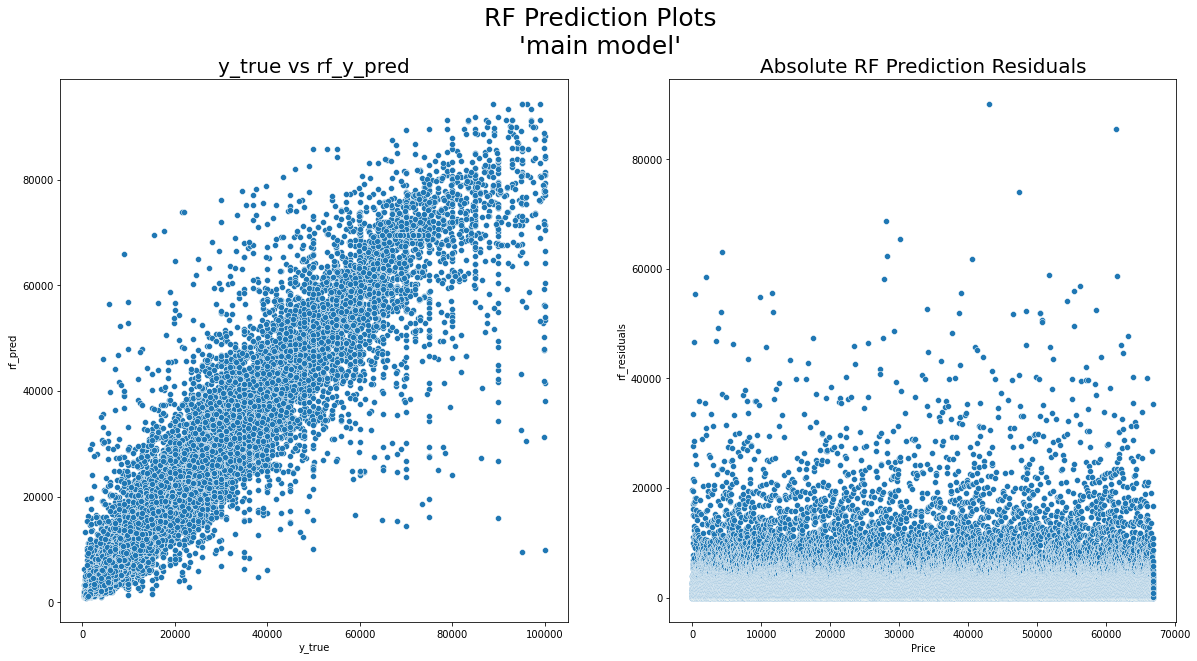

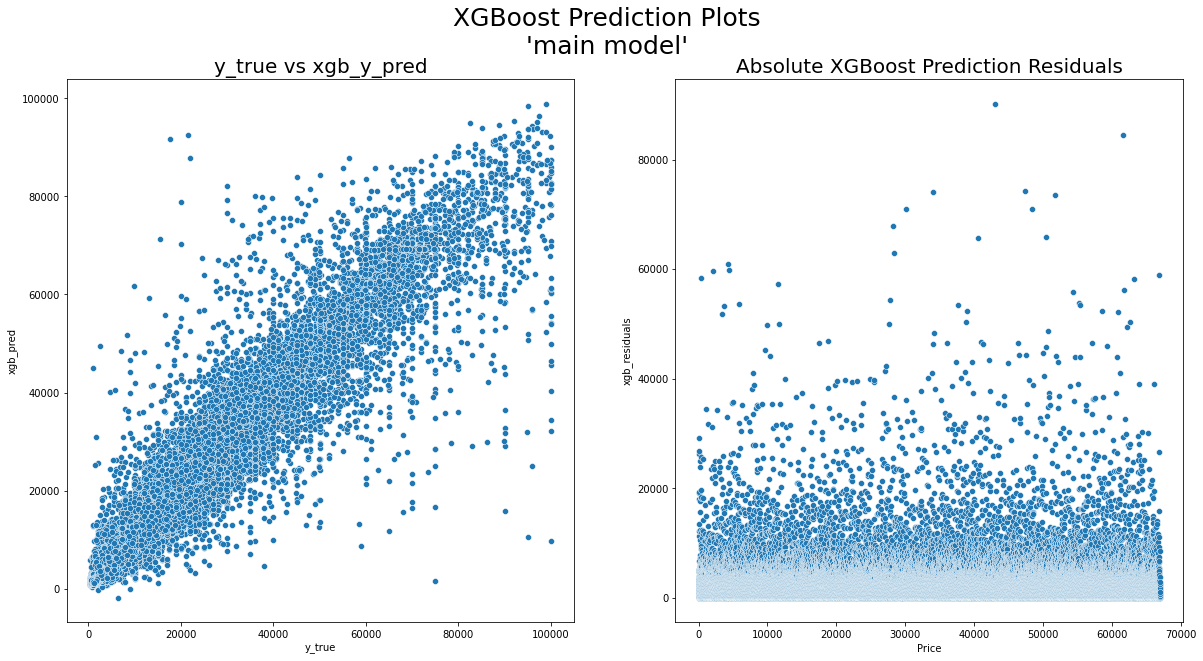

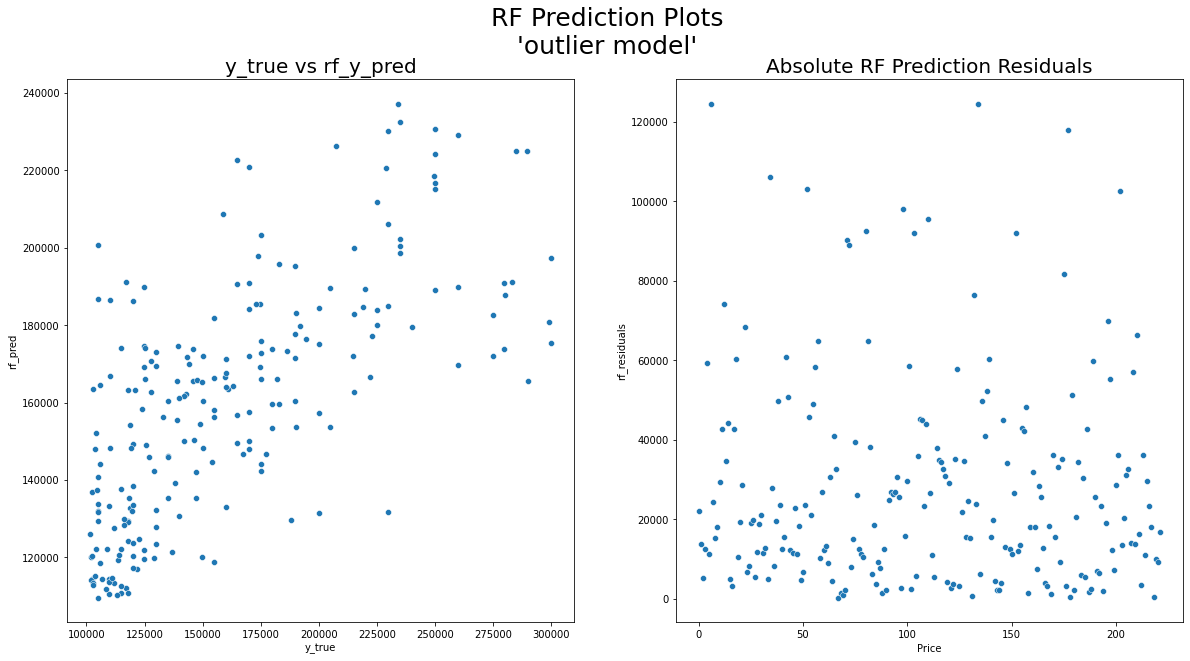

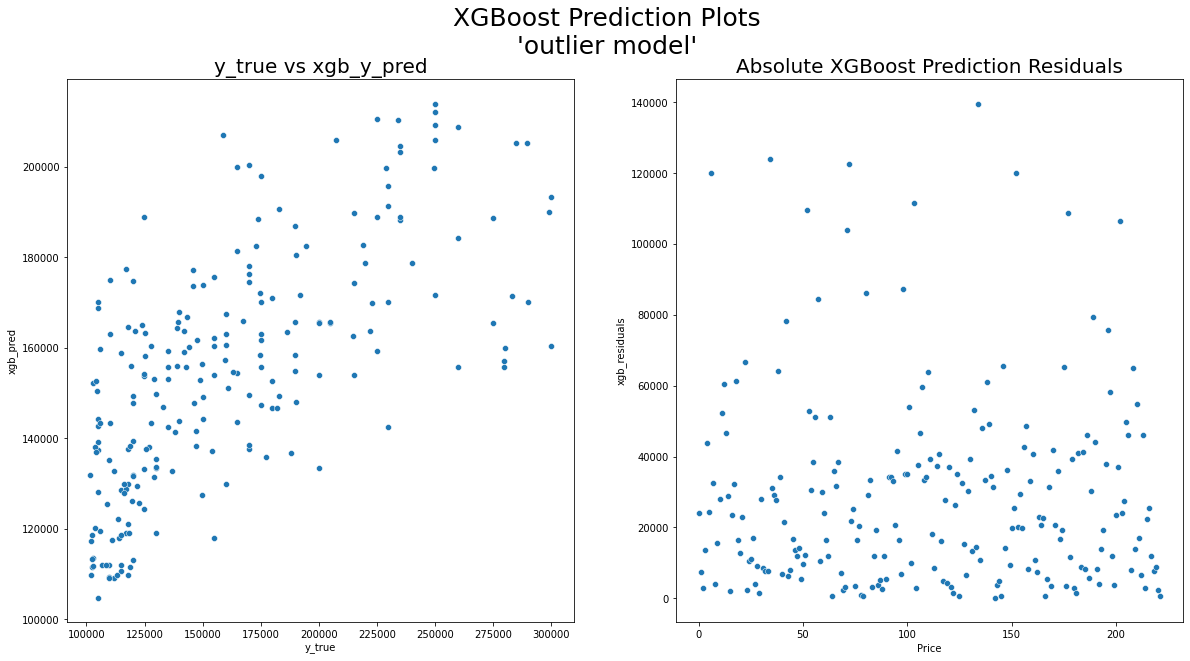

In [32]:

results_df = pd.DataFrame({'y_true': y_test, 'rf_pred': best_rf_y_pred, 'xgb_pred': xbg_preds, 'rf_residuals': y_test - best_rf_y_pred, 'xgb_residuals': y_test - xbg_preds})
outlier_results_df = pd.DataFrame({'y_true': y_test_outlier, 'rf_pred': best_rf_outlier_y_pred, 'xgb_pred': outlier_xbg_preds, 'rf_residuals': y_test_outlier - best_rf_outlier_y_pred, 'xgb_residuals': y_test_outlier - outlier_xbg_preds})

# RF plots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.scatterplot(x='y_true', y='rf_pred', data=results_df, ax=axes[0])
sns.scatterplot(data=abs(results_df['rf_residuals']), ax=axes[1])
plt.suptitle("RF Prediction Plots\n'main model'", fontsize=25)
axes[0].set_title("y_true vs rf_y_pred", fontsize=20)
axes[1].set_title("Absolute RF Prediction Residuals", fontsize=20)
axes[1].set_xlabel("Price")
plt.show()

# XGB plots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.scatterplot(x='y_true', y='xgb_pred', data=results_df, ax=axes[0])
sns.scatterplot(data=abs(results_df['xgb_residuals']), ax=axes[1])
plt.suptitle("XGBoost Prediction Plots\n'main model'", fontsize=25)
axes[0].set_title("y_true vs xgb_y_pred", fontsize=20)
axes[1].set_title("Absolute XGBoost Prediction Residuals", fontsize=20)
axes[1].set_xlabel("Price")
plt.show()

## Outlier Model
# RF plots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.scatterplot(x='y_true', y='rf_pred', data=outlier_results_df, ax=axes[0])
sns.scatterplot(data=abs(outlier_results_df['rf_residuals']), ax=axes[1])
plt.suptitle("RF Prediction Plots\n'outlier model'", fontsize=25)
axes[0].set_title("y_true vs rf_y_pred", fontsize=20)
axes[1].set_title("Absolute RF Prediction Residuals", fontsize=20)
axes[1].set_xlabel("Price")
plt.show()

# XGB plots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.scatterplot(x='y_true', y='xgb_pred', data=outlier_results_df, ax=axes[0])
sns.scatterplot(data=abs(outlier_results_df['xgb_residuals']), ax=axes[1])
plt.suptitle("XGBoost Prediction Plots\n'outlier model'", fontsize=25)
axes[0].set_title("y_true vs xgb_y_pred", fontsize=20)
axes[1].set_title("Absolute XGBoost Prediction Residuals", fontsize=20)
axes[1].set_xlabel("Price")
plt.show()

### Two Model Approach
In the second iteration of this model I applied some extra steps in the pre-processing stage. Firstly I filtered out all examples with a price <= £100,000 - this partition represented a 'typical' car. Whilst this threshold is somehwat arbritrary, it seemed like a good starting point for this dataset. If we had used a IQR technique across the whole dataset, any car over ~£45k would be excluded and a large proportion of data points would be dropped. Instead, I applied the IQR technique to the remaining 'outliers', which in my case was any car priced over £100,000. This was in order to create new outliers in the hope that we could retain as much genuine data as possible whilst extreme outliers (erroneous and genuine) are excluded. Using this technique, only 0.08% of the ingested data is dropped. The only limitation for this technique of splitting the data and training several models is that the 'hypercar model' has considerably less data (only about 2,000 examples) which means that after splitting into train, test and validation sets, the amount of data is quite small. 


#### Plotting the training of the XGBoost Models

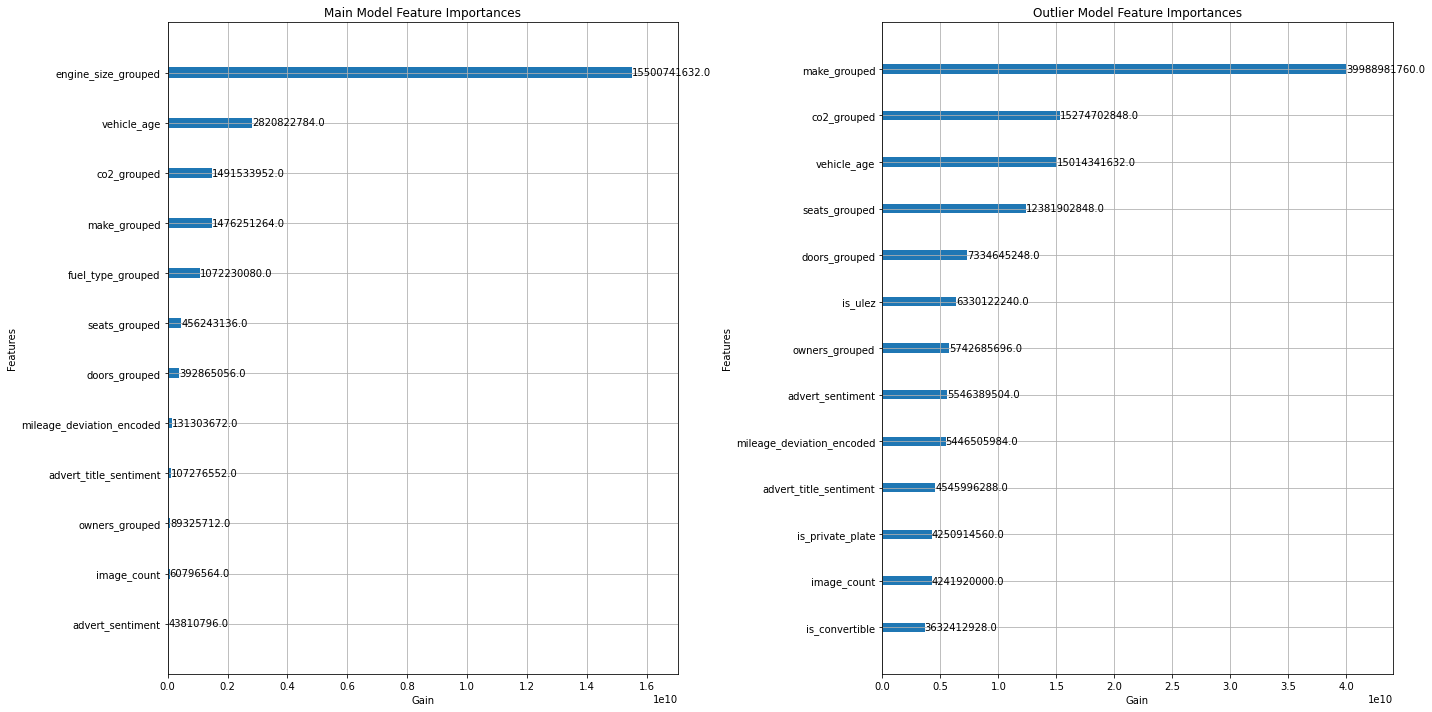

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

best_xgb_feature_map = dict(zip(features_out, best_xgb.feature_importances_))
best_xgb_feature_map = dict(sorted(best_xgb_feature_map.items(), key=lambda item: item[1], reverse=False))
outlier_best_xgb_map = dict(zip(outlier_features_out, outlier_best_xgb.feature_importances_))
outlier_best_xgb_map = dict(sorted(outlier_best_xgb_map.items(), key=lambda item: item[1], reverse=False))

xgb.plot_importance(best_xgb, ax=axes[0], importance_type="gain")
xgb.plot_importance(outlier_best_xgb, ax=axes[1], importance_type='gain')
axes[0].set_title("Main Model Feature Importances")
axes[0].set_xlabel("Gain")
axes[0].set_yticklabels(best_xgb_feature_map.keys())
axes[1].set_title("Outlier Model Feature Importances")
axes[1].set_xlabel("Gain")
axes[1].set_yticklabels(outlier_best_xgb_map.keys())
fig.tight_layout()

Text(0, 0.5, 'RMSE')

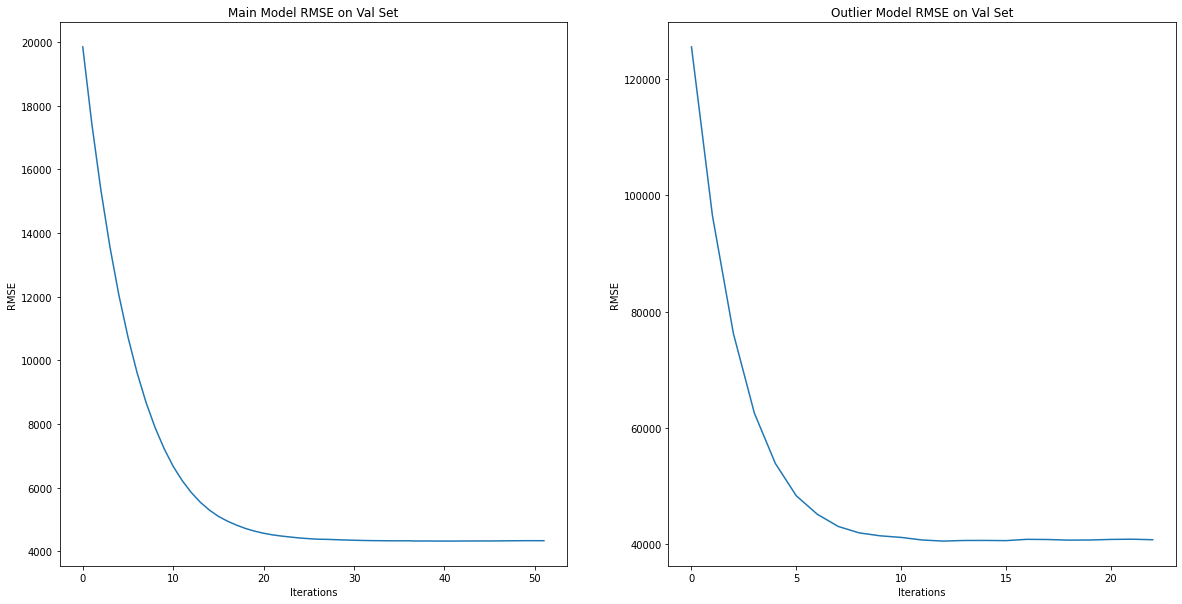

In [34]:
model_rmse = best_xgb.evals_result_['validation_0']['rmse']
outlier_model_rmse = outlier_best_xgb.evals_result_['validation_0']['rmse']
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
model_iters = [_ for _ in range(len(model_rmse))]
outlier_model_iters = [_ for _ in range(len(outlier_model_rmse))]

sns.lineplot(x=model_iters, y=model_rmse, ax=axes[0])
sns.lineplot(x=outlier_model_iters, y=outlier_model_rmse, ax=axes[1])
axes[0].set_title("Main Model RMSE on Val Set")
axes[1].set_title("Outlier Model RMSE on Val Set")
axes[0].set_xlabel("Iterations")
axes[1].set_xlabel("Iterations")
axes[0].set_ylabel("RMSE")
axes[1].set_ylabel("RMSE")

# Exploring Different XGB Implementation with Cross-Val
Before I started using the scikit api wrapper, I began exploring the 'default' XGBoost interface. 

In [16]:
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=1337, test_size=0.1)
xgb_dtrain = xgb.DMatrix(X_train, y_train)
# xgb_dval = xgb.DMatrix(X_val, y_val)
xgb_dtest = xgb.DMatrix(X_test, y_test)
param = {
    'max_depth': 16, 
    'eta': 0.1, 
    'objective': 'reg:squarederror',
    'eval_metric': 'mae'
    }
evallist = [(xgb_dtrain, 'train')]

In [17]:
num_round = 1000
bst = xgb.cv(param, xgb_dtrain, num_round, metrics='mae', early_stopping_rounds=5)

In [18]:
bst

,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
0,16925.475912,63.494392,16937.354818,143.993683
1,15323.347005,59.199637,15371.183268,144.886182
2,13912.184570,56.058313,14018.279622,144.999213
3,12671.313477,52.929467,12844.576823,144.611386
4,11574.495443,47.230916,11823.134115,147.078306
5,10608.156576,44.584086,10936.218424,145.644828
6,9755.651693,39.352714,10173.391602,143.546164
7,9005.082031,36.323444,9518.486979,144.321584
8,8343.281901,32.993114,8952.847331,141.189245
9,7757.857910,30.422887,8467.227214,137.015820
